## Modelo de Classificação 

#### **Objetivo principal:** criar modelo preditivo para determinar quais clientes deverão ter a próxima campanha de marketing direcionada.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    PowerTransformer, StandardScaler, MinMaxScaler,
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import treinar_e_validar_modelo_classificacao, organiza_resultados, grid_search_cv_classificador, metricas_grid_search, dataframe_coeficientes

sns.set_theme(palette="bright")

RANDOM_STATE = 42

In [2]:
df = pd.read_csv("../dados/customers_clustered.csv")
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProducts,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Marital_Status       2212 non-null   object 
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   MntWines             2212 non-null   int64  
 7   MntFruits            2212 non-null   int64  
 8   MntMeatProducts      2212 non-null   int64  
 9   MntFishProducts      2212 non-null   int64  
 10  MntSweetProducts     2212 non-null   int64  
 11  MntGoldProds         2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurchases    2212 non-null   i

#### Analisando a distribuição dos dados de cada feature

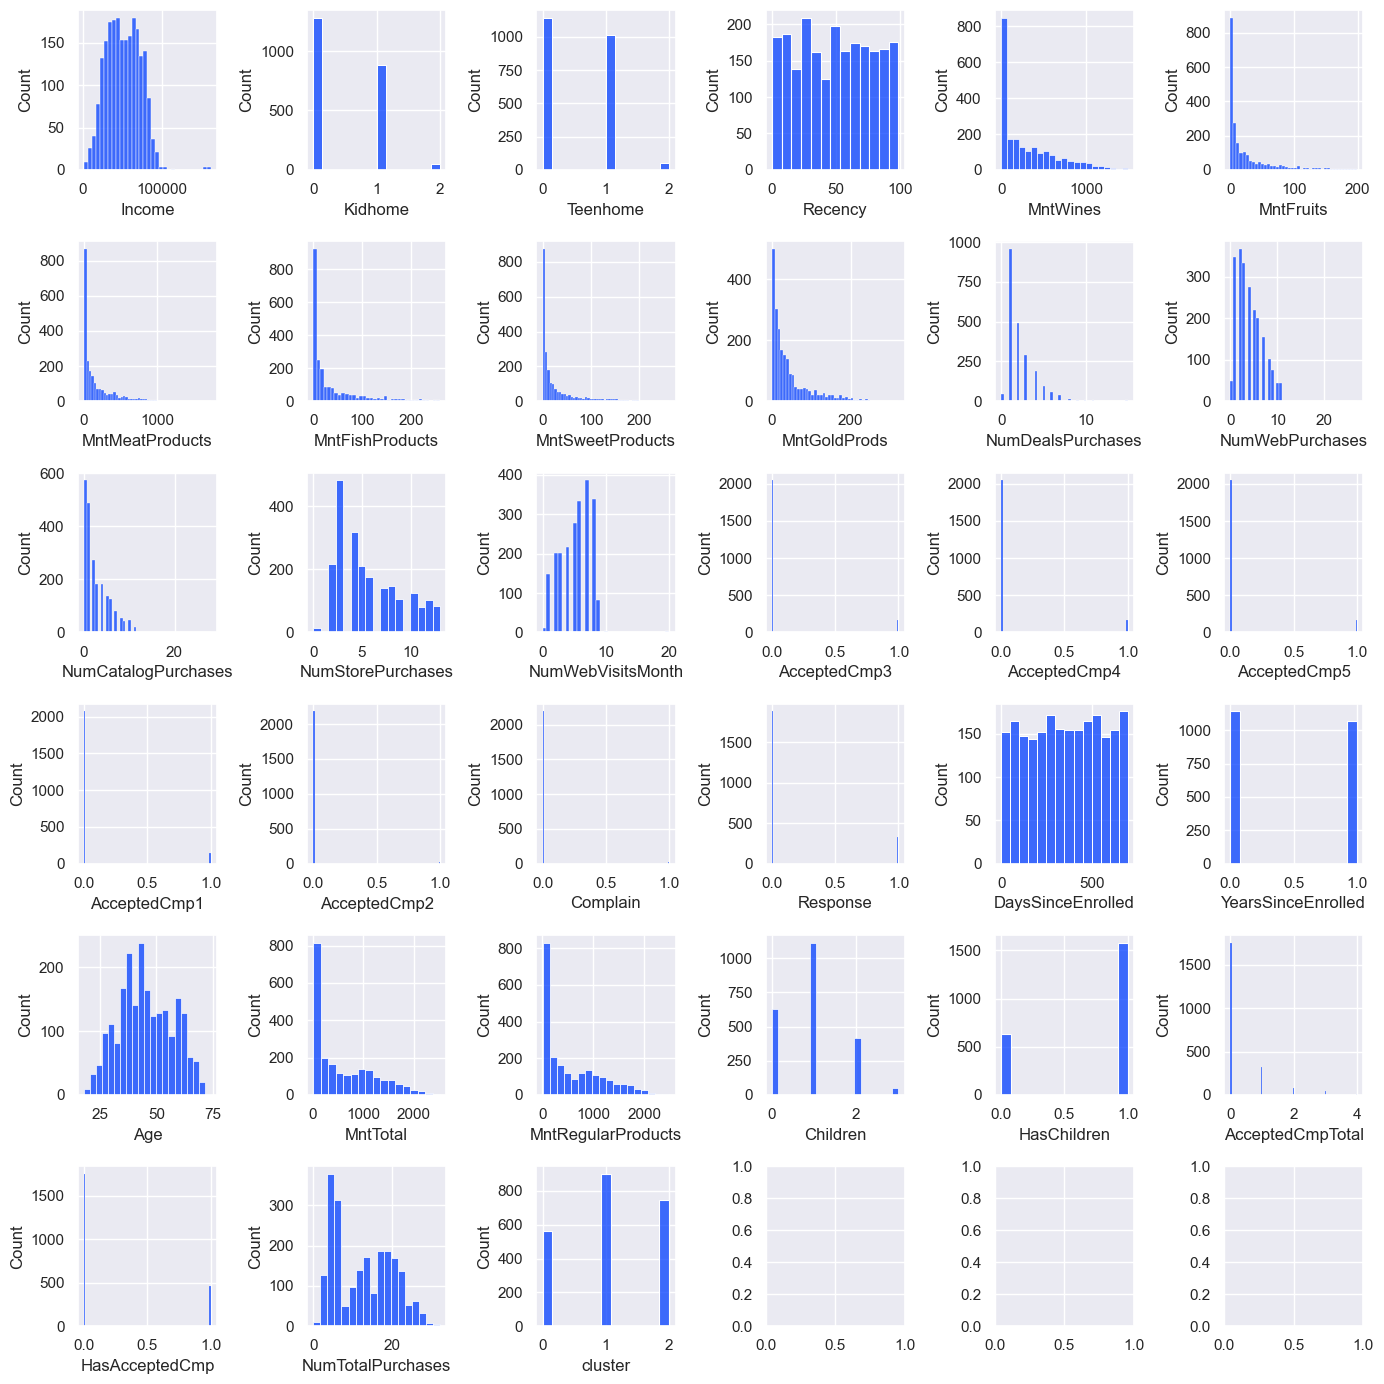

In [4]:
numerical_features = df.select_dtypes(include="number").columns

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(14, 14), tight_layout=True)

for ax, feature in zip(axs.flatten(), numerical_features):
    sns.histplot(x=feature, ax=ax, data=df)


#### Separando as colunas pelo tipo

In [5]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'DaysSinceEnrolled', 'YearsSinceEnrolled',
       'Age', 'AgeGroup', 'MntTotal', 'MntRegularProducts', 'Children',
       'HasChildren', 'AcceptedCmpTotal', 'HasAcceptedCmp',
       'NumTotalPurchases', 'cluster'],
      dtype='object')

**Padrões de separação das features:**

- MinMaxScaler: dados com distribuição uniforme
- StandardScaler: dados que seguem distribuição normal
- One Hot Enconder: features categóricas, mesmo que os dados sejam numéricos, mas que representam categorias através de números inteiros (0, 1, 2 ...)
- PowerTransform: dados que não seguem distribuições normais, pode ser usado para dados assimétricos (onde há uma distribuição dos dados maior para menores valores)

In [6]:
# target
coluna_target = ["Response"]

# Colunas categóricas
colunas_one_hot = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
    "cluster"
]

# onde temos uma distribuição uniforme dos dados e queremos padronizar a distruibuição dos dados (entre 0 e 1)
colunas_standard_scaler = [
    "Income",
    "Age",
]

# Quando a distribuição não é normal, e queremos normalizar
colunas_power_transform = df.columns[
   df.columns.str.startswith("Mnt") | df.columns.str.startswith("Num")
].tolist()

# onde já temos uma distribuição uniforme dos dados e queremos padronizar a distribuição dos dados (entre 0 e 1)
colunas_minmax = [
    col for col in df.columns if col not in coluna_target + colunas_one_hot + colunas_standard_scaler + colunas_power_transform
]

### Seleção de Features através de Testes Estatísticos 

**Objetivos**
- Para saber quais variáveis tem maior correlação com a feature "Response"
- Assim conseguimos ver qual feature influenciou mais na taxa de resposta da campanha piloto
- Conseguimos eliminar features que não tiveram importância pro modelo

**O que fazer?**
- Comparar coluna "Response" com colunas com dados numéricos contínuos: Teste de Mann-Whitneyu (dados binários, não pareados e não paramétricos)
- Comparar coluna "Response" com colunas com dados categóricos ou ordinais: Teste Qui-Quadrado (dados binários, não pareados e não paramétricos)

In [7]:
from scipy.stats import mannwhitneyu

# Teste de Mann-Whitneyu para colunas numéricas contínuas (considerando dados não paramétricos, não pareados, e com target binário)

resultados_mann_whitney = []

for coluna in colunas_power_transform + colunas_standard_scaler + colunas_minmax:
    grupo_0 = df[df['Response'] == 0][coluna]
    grupo_1 = df[df['Response'] == 1][coluna]

    stat, p = mannwhitneyu(grupo_0, grupo_1, alternative='two-sided')
    
    limite_p = 0.05

    resultados_mann_whitney.append({
        'feature': coluna,
        'statistic': stat,
        'p_value': p,
        'correlacao': 'Significativa' if p < limite_p else 'Não Significativa',
    })

df_resultados_mann_whitney = pd.DataFrame(resultados_mann_whitney).sort_values(by='p_value')

df_resultados_mann_whitney

,feature,statistic,p_value,correlacao
11,MntTotal,192654.0,4.581854e-29,Significativa
8,NumCatalogPurchases,197449.0,9.345664e-28,Significativa
12,MntRegularProducts,197174.5,4.828291e-27,Significativa
2,MntMeatProducts,200629.0,1.500867e-25,Significativa
16,Recency,413786.5,5.635857e-21,Significativa
0,MntWines,212789.0,1.214862e-20,Significativa
17,DaysSinceEnrolled,213562.5,2.391953e-20,Significativa
5,MntGoldProds,220662.5,9.199167e-18,Significativa
7,NumWebPurchases,226785.5,6.631408e-16,Significativa
13,NumTotalPurchases,230114.5,1.219836e-14,Significativa


In [8]:
from scipy.stats import chi2_contingency

# Teste de Qui-Quadrado para colunas categóricas ou ordinais (considerando dados não paramétricos, não pareados, e com target binário)

resultados_chi2 = []

for coluna in colunas_one_hot:

    tabela_contingencia = pd.crosstab(df['Response'], df[coluna])

    stat, p, dof, expected = chi2_contingency(tabela_contingencia)
    
    limite_p = 0.05

    resultados_chi2.append({
        'feature': coluna,
        'statistic': stat,
        'p_value': p,
        'correlacao': 'Significativa' if p < limite_p else 'Não Significativa',
    })

df_resultados_chi2 = pd.DataFrame(resultados_chi2).sort_values(by='p_value')

df_resultados_chi2

,feature,statistic,p_value,correlacao
15,AcceptedCmpTotal,404.972325,2.343753e-86,Significativa
4,HasAcceptedCmp,297.540379,1.131481e-66,Significativa
9,AcceptedCmp5,230.001425,5.957058e-52,Significativa
5,AcceptedCmp1,192.020306,1.151738e-43,Significativa
7,AcceptedCmp3,139.836123,2.891013e-32,Significativa
16,cluster,116.884201,4.158323e-26,Significativa
3,HasChildren,90.692841,1.677992e-21,Significativa
14,Children,93.812316,3.323089e-20,Significativa
8,AcceptedCmp4,69.785711,6.611005e-17,Significativa
13,YearsSinceEnrolled,65.971470,4.574976e-16,Significativa


OBS: As colunas que não tem correlação com a coluna "Response" podem ser excluídas da análise

In [9]:
#df = df.drop(columns=['Complain', 'NumDealsPurchases', 'Year_Birth', 'NumWebVisitsMonth'], axis=1)

df = df.drop(columns=['Complain', 'AgeGroup', 'NumDealsPurchases', 'Age', 'NumWebVisitsMonth'], axis=1)

In [10]:
colunas_power_transform.remove('NumWebVisitsMonth')
colunas_power_transform.remove('NumDealsPurchases')
colunas_one_hot.remove('Complain')
colunas_one_hot.remove('AgeGroup')
colunas_standard_scaler.remove('Age')

#### Definir as Etapas de Preprocessamento

In [11]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("one-hot", OneHotEncoder(), colunas_one_hot),
        ("standard", StandardScaler(), colunas_standard_scaler),
        ("minmax", MinMaxScaler(), colunas_minmax),
        ("power", PowerTransformer(), colunas_power_transform),
    ], remainder='passthrough'
)

preprocessamento

ColumnTransformer(remainder='passthrough',
                  transformers=[('one-hot', OneHotEncoder(),
                                 ['Education', 'Marital_Status', 'HasChildren',
                                  'HasAcceptedCmp', 'AcceptedCmp1',
                                  'AcceptedCmp2', 'AcceptedCmp3',
                                  'AcceptedCmp4', 'AcceptedCmp5', 'Kidhome',
                                  'Teenhome', 'YearsSinceEnrolled', 'Children',
                                  'AcceptedCmpTotal', 'cluster']),
                                ('standard', StandardScaler(), ['Income']),
                                ('minmax', MinMaxScaler(),
                                 ['Recency', 'DaysSinceEnrolled']),
                                ('power', PowerTransformer(),
                                 ['MntWines', 'MntFruits', 'MntMeatProducts',
                                  'MntFishProducts', 'MntSweetProducts',
                                  'MntGoldProds', 'NumWebPurchases',
                                  'NumCatalogPurchases', 'NumStorePurchases',
                                  'MntTotal', 'MntRegularProducts',
                                  'NumTotalPurchases'])])

In [12]:
preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(), colunas_one_hot),
    ], remainder='passthrough'
)

preprocessamento_arvore

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(),
                                 ['Education', 'Marital_Status', 'HasChildren',
                                  'HasAcceptedCmp', 'AcceptedCmp1',
                                  'AcceptedCmp2', 'AcceptedCmp3',
                                  'AcceptedCmp4', 'AcceptedCmp5', 'Kidhome',
                                  'Teenhome', 'YearsSinceEnrolled', 'Children',
                                  'AcceptedCmpTotal', 'cluster'])])

#### Definindo os Folds para validação cruzada

In [13]:
# Definido os Folds para validação cruzada 

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Criando modelos de classificação para identificar os clientes que responderam campanha piloto a fim de maximizar o lucro da próxima campanha

#### Função para criar o pipeline do modelo com o preprocessamento dos dados, e realizar a validação cruzada

In [14]:
# Função para criar o pipeline do modelo com o preprocessamento dos dados, e realizar a validação cruzada

def pipeline_model(X, y, model, preprocessor, kf):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scores = cross_validate(
        pipeline, 
        X, y,
        cv=kf,
        scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'average_precision'],
    )
    return scores

In [15]:
X = df.drop(columns=['Response'], axis=1)
y = df['Response']

In [16]:
scale_pos_weight = df['Response'].value_counts()[0] / df['Response'].value_counts()[1]

#### Executando os diferentes modelos de classificação

In [17]:
resultados = {
    'DummyClassifier': pipeline_model(X, y, DummyClassifier(strategy='stratified'), preprocessor=None, kf=kf),
    'LogisticRegression': pipeline_model(X, y, LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000), preprocessor=preprocessamento, kf=kf),
    'DecisionTreeClassifier': pipeline_model(X, y, DecisionTreeClassifier(class_weight='balanced'), preprocessor=preprocessamento_arvore, kf=kf),
    'XGBClassifier': pipeline_model(X, y, XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, n_jobs=-1), preprocessor=preprocessamento_arvore, kf=kf),
    'LGBMClassifier': pipeline_model(X, y, LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1), preprocessor=preprocessamento_arvore, kf=kf),
    'SVC': pipeline_model(X, y, SVC(class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE), preprocessor=preprocessamento, kf=kf),
    'KNeighborsClassifier': pipeline_model(X, y, KNeighborsClassifier(), preprocessor=preprocessamento, kf=kf),
}

c:\Users\brcprrcchave\AppData\Local\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\envs\machi

#### Reorganizando os resultados

In [18]:
from pprint import pprint

pprint(resultados)

{'DecisionTreeClassifier': {'fit_time': array([0.13793969, 0.07445693, 0.06747293, 0.07108068, 0.07397652]),
                            'score_time': array([0.11963487, 0.06272388, 0.06167316, 0.05955768, 0.06445789]),
                            'test_accuracy': array([0.87133183, 0.82392777, 0.83710407, 0.81900452, 0.87104072]),
                            'test_average_precision': array([0.39831463, 0.264644  , 0.30338894, 0.23184656, 0.36552623]),
                            'test_balanced_accuracy': array([0.75248095, 0.66935932, 0.70173134, 0.6250403 , 0.71808511]),
                            'test_f1': array([0.57777778, 0.43478261, 0.48571429, 0.36507937, 0.53658537]),
                            'test_precision': array([0.57352941, 0.42253521, 0.46575342, 0.38333333, 0.57894737]),
                            'test_recall': array([0.58208955, 0.44776119, 0.50746269, 0.34848485, 0.5       ]),
                            'test_roc_auc': array([0.75267942, 0.66733487, 0.7000796 

In [19]:
resultados.items()

dict_items([('DummyClassifier', {'fit_time': array([0.01062131, 0.00844216, 0.00628495, 0.00590038, 0.00424218]), 'score_time': array([0.06663513, 0.06813169, 0.04331207, 0.0336113 , 0.02526832]), 'test_accuracy': array([0.77200903, 0.74040632, 0.76244344, 0.73076923, 0.73755656]), 'test_balanced_accuracy': array([0.50998333, 0.47910051, 0.51062687, 0.48573501, 0.50846228]), 'test_f1': array([0.1512605 , 0.10852713, 0.16      , 0.13138686, 0.17142857]), 'test_precision': array([0.17307692, 0.11290323, 0.17241379, 0.12676056, 0.16216216]), 'test_recall': array([0.13432836, 0.10447761, 0.14925373, 0.13636364, 0.18181818]), 'test_roc_auc': array([0.51722769, 0.49218006, 0.55806965, 0.50886525, 0.48787073]), 'test_average_precision': array([0.15644942, 0.14939786, 0.17701196, 0.15179757, 0.14674174])}), ('LogisticRegression', {'fit_time': array([0.21516228, 0.21721816, 0.24410701, 0.34619665, 0.19135904]), 'score_time': array([0.0874939 , 0.10317826, 0.15431809, 0.08430505, 0.09198046]), '

In [20]:
# Adicionando a coluna 'time' para que seja a somatória do 'fit_time' e 'score_time'
for modelo, metrica in resultados.items():
    resultados[modelo]["time_seconds"] = resultados[modelo]["fit_time"] + resultados[modelo]["score_time"]

pprint(resultados)

{'DecisionTreeClassifier': {'fit_time': array([0.13793969, 0.07445693, 0.06747293, 0.07108068, 0.07397652]),
                            'score_time': array([0.11963487, 0.06272388, 0.06167316, 0.05955768, 0.06445789]),
                            'test_accuracy': array([0.87133183, 0.82392777, 0.83710407, 0.81900452, 0.87104072]),
                            'test_average_precision': array([0.39831463, 0.264644  , 0.30338894, 0.23184656, 0.36552623]),
                            'test_balanced_accuracy': array([0.75248095, 0.66935932, 0.70173134, 0.6250403 , 0.71808511]),
                            'test_f1': array([0.57777778, 0.43478261, 0.48571429, 0.36507937, 0.53658537]),
                            'test_precision': array([0.57352941, 0.42253521, 0.46575342, 0.38333333, 0.57894737]),
                            'test_recall': array([0.58208955, 0.44776119, 0.50746269, 0.34848485, 0.5       ]),
                            'test_roc_auc': array([0.75267942, 0.66733487, 0.7000796 

In [21]:
df_resultados = pd.DataFrame(resultados).T.reset_index().rename(columns={"index": "model"})
df_resultados = df_resultados.drop(columns=['fit_time', 'score_time'], axis=1)#, inplace=True)
df_resultados

,model,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,"[0.7720090293453724, 0.7404063205417607, 0.762...","[0.5099833280406478, 0.4791005080978088, 0.510...","[0.15126050420168066, 0.10852713178294573, 0.1...","[0.17307692307692307, 0.11290322580645161, 0.1...","[0.13432835820895522, 0.1044776119402985, 0.14...","[0.5172276913305811, 0.4921800571610035, 0.558...","[0.15644942362001799, 0.14939785646635145, 0.1...","[0.07725644111633301, 0.07657384872436523, 0.0..."
1,LogisticRegression,"[0.8306997742663657, 0.8171557562076749, 0.807...","[0.8328040647824706, 0.8064266433788504, 0.788...","[0.5989304812834224, 0.5668449197860963, 0.545...","[0.4666666666666667, 0.44166666666666665, 0.42...","[0.835820895522388, 0.7910447761194029, 0.7611...","[0.9151317878691648, 0.8831176563988569, 0.894...","[0.6788817686418479, 0.6928456527289831, 0.692...","[0.3026561737060547, 0.32039642333984375, 0.39..."
2,DecisionTreeClassifier,"[0.871331828442438, 0.8239277652370203, 0.8371...","[0.7524809463321689, 0.6693593204191807, 0.701...","[0.5777777777777777, 0.43478260869565216, 0.48...","[0.5735294117647058, 0.4225352112676056, 0.465...","[0.582089552238806, 0.44776119402985076, 0.507...","[0.7526794220387426, 0.6673348682121307, 0.700...","[0.39831463089905317, 0.2646440009281795, 0.30...","[0.25757455825805664, 0.13718080520629883, 0.1..."
3,XGBClassifier,"[0.8690744920993227, 0.8600451467268623, 0.893...","[0.7388853604318831, 0.7029017148301048, 0.777...","[0.5606060606060606, 0.5079365079365079, 0.635...","[0.5692307692307692, 0.5423728813559322, 0.661...","[0.5522388059701493, 0.47761194029850745, 0.61...","[0.9046919657033979, 0.862238012067323, 0.9102...","[0.5922503825457375, 0.6103682743888703, 0.689...","[0.8245861530303955, 0.5067017078399658, 0.413..."
4,LGBMClassifier,"[0.8939051918735892, 0.873589164785553, 0.8891...","[0.8025762146713242, 0.7231462369006034, 0.781...","[0.656934306569343, 0.5483870967741935, 0.6315...","[0.6428571428571429, 0.5964912280701754, 0.636...","[0.6716417910447762, 0.5074626865671642, 0.626...","[0.9198555096856145, 0.8699388694823754, 0.912...","[0.7016451984959942, 0.6398575388876983, 0.686...","[0.6423499584197998, 0.7913033962249756, 0.417..."
5,SVC,"[0.8419864559819413, 0.8148984198645598, 0.796...","[0.8210543029533185, 0.8050968561448079, 0.812...","[0.6022727272727273, 0.5638297872340425, 0.554...","[0.48623853211009177, 0.4380165289256198, 0.41...","[0.7910447761194029, 0.7910447761194029, 0.835...","[0.9047316608447127, 0.8914139409336297, 0.899...","[0.6211442116086818, 0.6928079498994778, 0.698...","[0.8519885540008545, 0.7709062099456787, 0.841..."
6,KNeighborsClassifier,"[0.8690744920993227, 0.8510158013544018, 0.875...","[0.6530247697681804, 0.6178548745633534, 0.681...","[0.4423076923076923, 0.36538461538461536, 0.49...","[0.6216216216216216, 0.5135135135135135, 0.642...","[0.34328358208955223, 0.2835820895522388, 0.40...","[0.7635360431883138, 0.7785011114639568, 0.796...","[0.4147883774749836, 0.4091892334080317, 0.446...","[0.9074399471282959, 0.2588810920715332, 0.230..."


In [22]:
df_resultados = df_resultados.explode(
    df_resultados.columns[1:].to_list()
).reset_index(drop=True)

df_resultados

,model,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.772009,0.509983,0.151261,0.173077,0.134328,0.517228,0.156449,0.077256
1,DummyClassifier,0.740406,0.479101,0.108527,0.112903,0.104478,0.49218,0.149398,0.076574
2,DummyClassifier,0.762443,0.510627,0.16,0.172414,0.149254,0.55807,0.177012,0.049597
3,DummyClassifier,0.730769,0.485735,0.131387,0.126761,0.136364,0.508865,0.151798,0.039512
4,DummyClassifier,0.737557,0.508462,0.171429,0.162162,0.181818,0.487871,0.146742,0.02951
5,LogisticRegression,0.8307,0.832804,0.59893,0.466667,0.835821,0.915132,0.678882,0.302656
6,LogisticRegression,0.817156,0.806427,0.566845,0.441667,0.791045,0.883118,0.692846,0.320396
7,LogisticRegression,0.807692,0.788597,0.545455,0.425,0.761194,0.89403,0.692719,0.398425
8,LogisticRegression,0.850679,0.849774,0.629213,0.5,0.848485,0.918319,0.709409,0.430502
9,LogisticRegression,0.848416,0.835953,0.617143,0.495413,0.818182,0.920132,0.69144,0.28334


**Qual métrica vamos escolher para a melhor para esse contexto?**
- Contexto: Queremos conseguir identificar os clientes que vão responder a campanha de marketing.
- Nessa aplicação é pior não oferecer a campanha para um possível comprador, do que oferecer pra alguém que não vai comprar. 
- Portanto, para esse problema o **recall** é mais importante que a precisão.
- Mas também é bom ter um balanço de precisão e recall para não gastar dinheiro excessivamente nas campanhas de marketing com clientes que não serão influenciados pela campanha, então a métrica **average_precision** também deve ser levada em consideração (caso tenhamos modelos com recall similar)

In [23]:
df_resultados.groupby('model').mean().sort_values(by='test_recall')

,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,
DummyClassifier,0.748637,0.498782,0.144521,0.149463,0.141248,0.512843,0.15628,0.05449
KNeighborsClassifier,0.863928,0.639354,0.411641,0.586848,0.318091,0.791776,0.421048,0.395861
DecisionTreeClassifier,0.844482,0.693339,0.479988,0.48482,0.47716,0.692716,0.312744,0.158595
XGBClassifier,0.879308,0.742404,0.577493,0.616037,0.54654,0.902388,0.634968,0.605062
LGBMClassifier,0.888793,0.775221,0.623737,0.637704,0.612709,0.910477,0.670664,0.632536
SVC,0.8264,0.812504,0.580414,0.459236,0.792673,0.904027,0.673509,0.776841
LogisticRegression,0.830929,0.822711,0.591517,0.465749,0.810945,0.906146,0.693059,0.347064


In [24]:
df_resultados.groupby('model').mean().sort_values(by='test_average_precision')

,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,
DummyClassifier,0.748637,0.498782,0.144521,0.149463,0.141248,0.512843,0.15628,0.05449
DecisionTreeClassifier,0.844482,0.693339,0.479988,0.48482,0.47716,0.692716,0.312744,0.158595
KNeighborsClassifier,0.863928,0.639354,0.411641,0.586848,0.318091,0.791776,0.421048,0.395861
XGBClassifier,0.879308,0.742404,0.577493,0.616037,0.54654,0.902388,0.634968,0.605062
LGBMClassifier,0.888793,0.775221,0.623737,0.637704,0.612709,0.910477,0.670664,0.632536
SVC,0.8264,0.812504,0.580414,0.459236,0.792673,0.904027,0.673509,0.776841
LogisticRegression,0.830929,0.822711,0.591517,0.465749,0.810945,0.906146,0.693059,0.347064


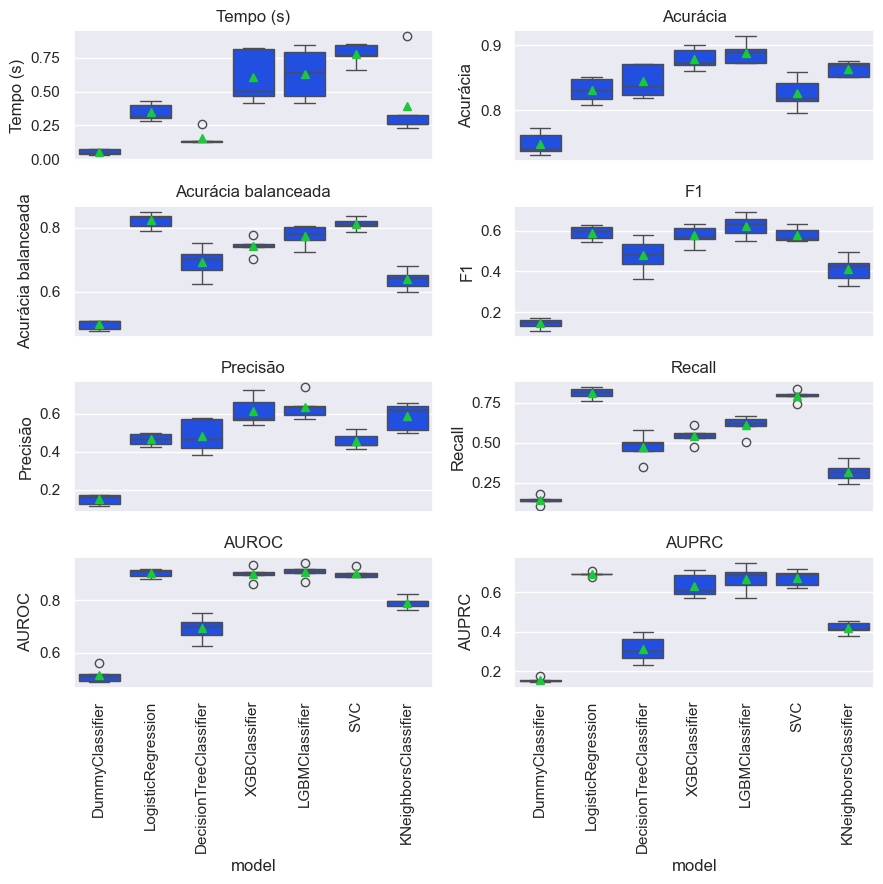

In [25]:
plot_comparar_metricas_modelos(df_resultados)

**Análise dos Resultados**
- **Melhor modelo**: LogisticRegression (foi o que apresentou maior recall e melhor precision-recall)

- **OBS**: Também devemos escolher um modelo que seja mais fácil identificar as features mais significativas envolvidas na taxa de resposta do cliente. Nesse caso os modelos de Regressão Logística tem certa vantagem também.

#### Otimizando o modelo rodando o GridSearch com diferentes parametros

In [26]:
pipeline_melhor_modelo = Pipeline([
    ('preprocessor', preprocessamento),
    ('model', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)),
])

pipeline_melhor_modelo

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status',
                                                   'HasChildren',
                                                   'HasAcceptedCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Kidhome',
                                                   'Teenhome',
                                                   'YearsSinceEnrolled',
                                                   'Children',
                                                   'AcceptedCmpTotal',
                                                   'cluster']),
                                                 ('standard', Sta...
                                                 ('minmax', MinMaxScaler(),
                                                  ['Recency',
                                                   'DaysSinceEnrolled']),
                                                 ('power', PowerTransformer(),
                                                  ['MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'MntTotal',
                                                   'MntRegularProducts',
                                                   'NumTotalPurchases'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [27]:
param_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__solver': ['liblinear', 'saga', 'lbfgs'], 
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__l1_ratio': [0.1, 0.5, 0.9],                     # Apenas para penalty='elasticnet'
    'model__max_iter': [100, 200, 500],
}

In [28]:
grid_search = GridSearchCV(
    pipeline_melhor_modelo,
    param_grid,
    scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'average_precision'],
    n_jobs=-1,
    refit='recall',
    cv=kf
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one-hot',
                                                                         OneHotEncoder(),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'HasChildren',
                                                                          'HasAcceptedCmp',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'Kidhome',
                                                                          'Teenh...
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__l1_ratio': [0.1, 0.5, 0.9],
                         'model__max_iter': [100, 200, 500],
                         'model__penalty': ['l1', 'l2', 'elasticnet', None],
                         'model__solver': ['liblinear', 'saga', 'lbfgs']},
             refit='recall',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'])

In [29]:
grid_search.fit(X, y)

c:\Users\brcprrcchave\AppData\Local\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
900 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\brcprrcchave\AppData\Local\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\brcprrcchave\AppData\Local\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *ar

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one-hot',
                                                                         OneHotEncoder(),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'HasChildren',
                                                                          'HasAcceptedCmp',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'Kidhome',
                                                                          'Teenh...
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__l1_ratio': [0.1, 0.5, 0.9],
                         'model__max_iter': [100, 200, 500],
                         'model__penalty': ['l1', 'l2', 'elasticnet', None],
                         'model__solver': ['liblinear', 'saga', 'lbfgs']},
             refit='recall',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'])

In [30]:
grid_search.best_params_

{'model__C': 0.1,
 'model__l1_ratio': 0.1,
 'model__max_iter': 200,
 'model__penalty': 'elasticnet',
 'model__solver': 'saga'}

In [31]:
grid_search.best_score_

np.float64(0.8199004975124378)

In [32]:
metricas_grid_search(grid_search)

mean_fit_time: 0.9868366241455078
mean_score_time: 0.0893852710723877
mean_test_accuracy: 0.8273127483325332
mean_test_balanced_accuracy: 0.8242573409548004
mean_test_f1: 0.5893754760648288
mean_test_precision: 0.4608081304974946
mean_test_recall: 0.8199004975124378
mean_test_roc_auc: 0.9035600469605551
mean_test_average_precision: 0.6767420722592543


**OBS**: Função np.nanmax() retorno o maior valor de uma array ignorando os valores 'nan' existentes, pois se usasse apenas np.max() daria esse erro

#### Vendo qual melhor resultado da métrica 'average_precision' foi obtido no grid_search e com quais parametros

In [33]:
np.nanmax(grid_search.cv_results_["mean_test_average_precision"])

np.float64(0.6962022272586036)

In [34]:
grid_search.cv_results_["params"][np.nanargmax(grid_search.cv_results_["mean_test_average_precision"])]

{'model__C': 10,
 'model__l1_ratio': 0.1,
 'model__max_iter': 100,
 'model__penalty': 'l2',
 'model__solver': 'saga'}

#### Analisando as Features de Maior Importância pro Modelo

*Métodos que serão utilizados:*
- Permutation Importance
- Coeficientes das Features

#### Permutation Importance

In [35]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status',
                                                   'HasChildren',
                                                   'HasAcceptedCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Kidhome',
                                                   'Teenhome',
                                                   'YearsSinceEnrolled',
                                                   'Children',
                                                   'AcceptedCmpTotal',
                                                   'cluster']),
                                                 ('standard', Sta...
                                                 ('power', PowerTransformer(),
                                                  ['MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'MntTotal',
                                                   'MntRegularProducts',
                                                   'NumTotalPurchases'])])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.1, max_iter=200,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [36]:
perm_imp = permutation_importance(
    grid_search.best_estimator_, 
    X, 
    y,
    n_repeats=10,
    random_state=RANDOM_STATE, 
    n_jobs=-1,
    scoring='recall'
)

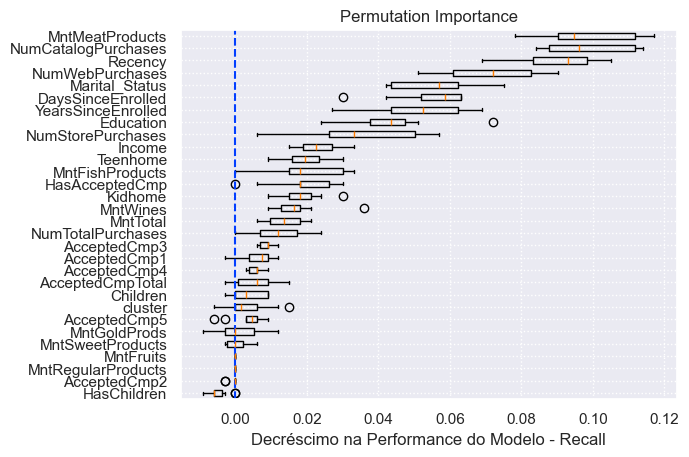

In [37]:
fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])

ax.axvline(x=0, linestyle='--')
ax.set_xlabel('Decréscimo na Performance do Modelo - Recall')
ax.set_title('Permutation Importance')
ax.grid(True, linestyle=":")

plt.show()


#### Analisando coeficientes das features de maior importância pro modelo

In [38]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_['model'].coef_[0],
    grid_search.best_estimator_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
minmax__Recency,-2.188288
power__NumStorePurchases,-0.543322
one-hot__Marital_Status_Partner,-0.487214
one-hot__Education_Basic,-0.428738
one-hot__AcceptedCmpTotal_0,-0.399359
one-hot__HasAcceptedCmp_0,-0.399359
one-hot__YearsSinceEnrolled_0,-0.386801
one-hot__AcceptedCmp3_0,-0.376496
power__NumTotalPurchases,-0.375012
one-hot__AcceptedCmp1_0,-0.348967


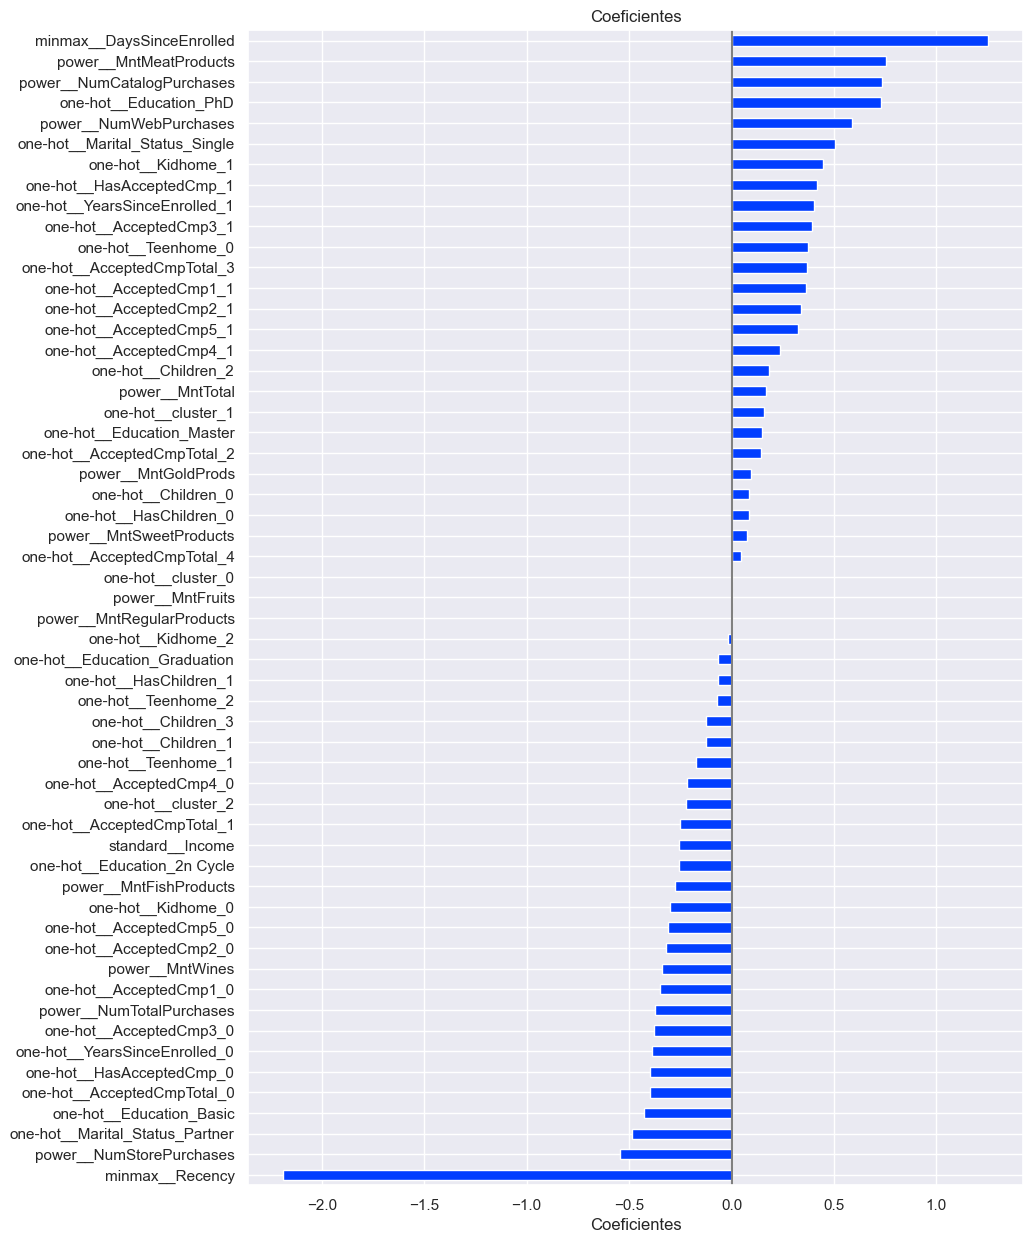

In [39]:
plot_coeficientes(coefs)

##### **CONCLUSÕES** - Quais perfil de cliente que deverá ter o direcionamento de marketing?

<u> Baseado nos coeficientes das features do modelo LogisticRegression: </u>
- Clientes que aceitaram campanhas de marketing anteriores (mais propensos a aceitar a próxima campanha)
- Clientes antigos (cadastrados na base de dados a mais tempo - DaysSinceEnrolled)
- Preferência por clientes solteiros do que com algum parceiro.
- Clientes que não estão a muitos dias sem fazer compras (Recency)
- Clientes que compram mais no site da empresa ou conforme catálogo, e não tanto na loja.
- Clientes que preferem comprar mais carnes e não tanto vinhos
- Clientes com maiores níveis educacionais (PHD), evitar clientes com educação básica apenas

<u>  ATENÇÃO: </u> 
- Não podemos interpretar os coeficientes acima e interpretar que coeficientes positivos favorecer a chance do cliente atender a próxima campanha de marketing, e coeficientes negativos diminuem as chances. Temos que ponder que algumas features foram criadas a partir de operações matemáticas envolvendo outras features (MntTotal,MntRegularProducts) e essa multicolinearidade dos dados pode influenciar nos coeficientes do modelo. 
- Além disso, os dados passaram por métodos de preprocessamento onde houve ajuste de escala dos dados para melhor resultado dos modelos, e isso também prejudica a interpretabilidade dos coeficientes.

**Conclusão: O mais adequado a se fazer é utilizar o modelo treinado e otimizado nesse projeto para definir quais clientes tem maiores chances de responder a próxima campanha de marketing e direcionar para estes clientes a campanha**

#### Matriz de Confusão

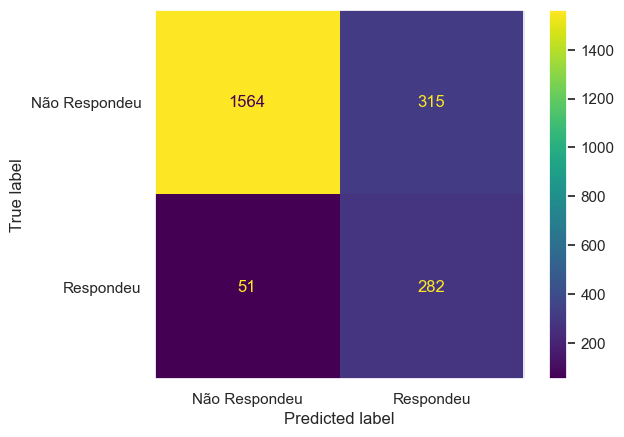

In [40]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = ['Não Respondeu', 'Respondeu'],
)

plt.grid(False)
plt.show()

### Precision-Recall Curve

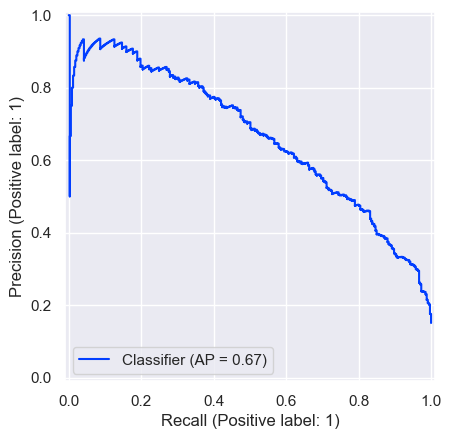

In [41]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=kf, n_jobs=-1, method="decision_function")

prc = PrecisionRecallDisplay.from_predictions(y, y_pred)

### Curva ROC

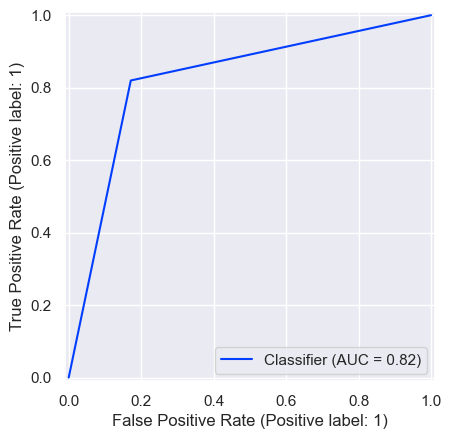

In [42]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=kf, n_jobs=-1)

prc = RocCurveDisplay.from_predictions(y, y_pred)

#### Estimando ROI - Retorno sobre Investimento - Nova Campanha de Marketing

In [43]:
custo_campanha_piloto = 6.720*(10**6)
print(f"Custo Total da Campanha Piloto: {custo_campanha_piloto}")

receita_gerada_piloto = 3.674*10**6
print(f"Receita Total da Campanha Piloto: {receita_gerada_piloto}")

lucro_campanha_piloto = receita_gerada_piloto - custo_campanha_piloto
print(f"ROI da Campanha Piloto: {lucro_campanha_piloto:.0f} equivalente a {(receita_gerada_piloto-custo_campanha_piloto)/custo_campanha_piloto:.0%} do custo da campanha")

Custo Total da Campanha Piloto: 6720000.0
Receita Total da Campanha Piloto: 3674000.0
ROI da Campanha Piloto: -3046000 equivalente a -45% do custo da campanha


In [44]:
custo_por_cliente = custo_campanha_piloto / df.shape[0]
print(f"Custo por Cliente: {custo_por_cliente:.2f}")

receita_por_cliente = receita_gerada_piloto / df[df['Response']==1].shape[0]
print(f"Receita por Cliente: {receita_por_cliente:.2f}")


Custo por Cliente: 3037.97
Receita por Cliente: 11033.03


In [45]:
y_pred = grid_search.best_estimator_.predict(X)
cm = confusion_matrix(y, y_pred)
cm

array([[1564,  315],
       [  51,  282]])

In [46]:
y_pred = grid_search.best_estimator_.predict(X)
cm = confusion_matrix(y, y_pred)
cm

array([[1564,  315],
       [  51,  282]])

In [47]:
TP = cm[1, 1]  # Verdadeiros Positivos
TN = cm[0, 0]  # Verdadeiros Negativos
FP = cm[0, 1]  # Falsos Positivos   
FN = cm[1, 0]  # Falsos Negativos

In [48]:
custo_campanha_nova = custo_por_cliente*(TP+FP)
print(f"Custo da Campanha nova: {custo_campanha_nova:.0f}")

receita_campanha_nova = receita_por_cliente*TP
print(f"Receita da Campanha Nova: {receita_campanha_nova:.0f}")

lucro_campanha_nova = receita_campanha_nova - custo_campanha_nova
print(f"ROI da Campanha Nova: {lucro_campanha_nova:.0f} equivalente a {(receita_campanha_nova-custo_campanha_nova)/custo_campanha_nova:.0%} do custo da campanha")

Custo da Campanha nova: 1813671
Receita da Campanha Nova: 3111315
ROI da Campanha Nova: 1297644 equivalente a 72% do custo da campanha


#### **Resumo do ROI Estimado**

CAMPANHA | GASTO | RECEITA | ROI BRUTO | ROI (%)
---------|-------|---------|-----------|---------
Piloto | 6.720MU | 3.674MU | <font color='red'> -3.046MU | <font color='red'>- 45%
Nova (Previsão) | 18.136MU | 31.113MU | <font color='green'>12.976MU | <font color='green'>72%

OBS: Estimativa de retorno direcionando a próxima campanha de marketing para os clientes definidos pelo modelo preditivo.

#### Exportando o modelo

In [50]:
from joblib import dump

dump(grid_search.best_estimator_, '../modelos/logistic_regression_marketing_campaign.joblib')

['../modelos/logistic_regression_marketing_campaign.joblib']